# **Voyager Signal Similarity Search with β-VAE (Colab Tutorial)**

### Introduction

In this tutorial, we will use real Voyager-1 radio spectrogram data from the Breakthrough Listen public archive to demonstrate a content-based signal search. We aim to find signals that look morphologically similar to a given “query” signal in Voyager's spectrograms. The dataset consists of six 5-minute scans of Voyager 1 acquired by the Green Bank Telescope in July 2020 (3 scans pointed ON the Voyager spacecraft and 3 OFF target) 1 . For simplicity, we will ignore the ON/OFF labeling (i.e. we won’t perform interference filtering by removing OFF-target signals 2 ). Instead, we’ll treat all scans uniformly as a pool of spectrogram data in which to search for lookalike signals.

### Approach

We follow a simplified version of the method by Ma et al. (2024) 3 . First, we use an energy detection approach to extract small signal snippets from the full spectrogram – essentially finding time- frequency patches with power significantly above the noise floor 4 . These snippets (for example, containing narrowband Doppler-drifted carrier signals) will be our “catalog” of candidate signals. Next, we load a pretrained β-Variational Autoencoder (β-VAE) encoder model provided by Peter Ma et al. 3 . This neural network encodes each spectrogram snippet into a low-dimensional latent feature vector that captures its salient morphological features (shape, bandwidth, drift rate, etc.). Finally, given a selected query snippet, we compute the cosine similarity between the query’s embedding and all other snippet embeddings 5 to retrieve the most similar signals. We will display the top 10 matches as images and discuss the results.

### Requirements

This notebook uses TensorFlow (with GPU support) and common scientific Python packages (NumPy, h5py, etc.) which are pre-installed in Colab. We will also install Blimpy (Breakthrough Listen I/O toolkit) to help read .h5 spectrogram files. The β-VAE encoder model (vae_encoder.h5) will be downloaded from Peter Ma’s GitHub repository and loaded with Keras.
Let's get started by importing necessary libraries and preparing the data.

## Setup and Data Loading

First, let's clone the Github repo into this Google Colab runtime so that we have access to all the files we'll need:

In [1]:
!git clone https://github.com/elanlavie/VoyagerMLTutorial.git

import os
os.chdir('VoyagerMLTutorial')

Cloning into 'VoyagerMLTutorial'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 16.60 MiB | 6.81 MiB/s, done.
Resolving deltas: 100% (13/13), done.


Next, let's install Blimpy for reading the HDF5 (.h5) filterbank files, and import required libraries:

In [2]:
!pip install blimpy # BL data reader library

import numpy as np
import h5py
from blimpy import Waterfall
import matplotlib.pyplot as plt

# Set matplotlib for inline plotting (if in Colab, this is usually automatic)
%matplotlib inline

Next, we assume the six Voyager .h5 files are available in the Colab environment (e.g. uploaded or in Drive). For example, they might be named like voyager1_scan11.h5, voyager1_scan12.h5, ... voyager1_scan16.h5 corresponding to the 3 ON + 3 OFF scans (scans 11, 13, 15 are ON; 12, 14, 16 are OFF) 1 2 . We will list the files and load them one by one to build our snippet catalog. Each file contains a **spectrogram** (waterfall plot) of one 5-min scan: power as a function of time and frequency. The time resolution in these files is on the order of 10–18 seconds per bin (the data here use ~10.7 s integration) and frequency resolution ~2.79 Hz per bin 6 .

We'll iterate through each file, read its data, and identify high-energy patches. For this simple energy detector, we define a patch (snippet) as a fixed frequency bandwidth of ~715 Hz (which is 256 frequency bins at 2.79 Hz resolution 7 8 ) across the full time span of the scan. We slide this 256-bin window across the band and extract a snippet whenever the window contains a signal above a set threshold. The threshold can be set as, for example, mean + 5σ of the noise power. This approach will catch narrowband signals that
stand out above noise in that frequency interval (as used in Ma et al. for initial energy detection.

Let's implement the snippet extraction:

In [3]:
# You can edit this variable to match whichever directory you will use to store your data files
data_directory = 'voyager_2020_data'

# Read the necessary URLs from data_urls.lst
with open('data_urls.lst') as file:
    data_urls = file.read().splitlines()

# Local imports
import download_progress

# Download each one into a directory called 'data' if they aren't already present.
for url in data_urls:
    download_progress.download_file_with_progress_bar(url, download_dir=data_directory)

voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5:   0%|          | 0.00/4…

voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5:   0%|          | 0.00/5…

voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5:   0%|          | 0.00/5…

voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5:   0%|          | 0.00/5…

voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5:   0%|          | 0.00/4…

voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5:   0%|          | 0.00/4…

In [4]:
# List your Voyager .h5 files (update the pattern if needed)
import glob
file_list = sorted(glob.glob("voyager_2020_data/*.h5"))
print("Found files:", file_list)

snippets = []        # to store extracted snippet arrays
snippet_locs = []    # to store metadata (file name and freq range of each snippet)

# Parameters
freq_window = 256  # number of frequency bins ~715 Hz
sigma_threshold = 5.0  # threshold in terms of noise standard deviation

for fname in file_list:
    # Load the spectrogram data using blimpy
    wf = Waterfall(fname, load_data=True)
    data = wf.data.squeeze()  # shape: (time_bins, freq_bins)
    print(f"{fname}: data shape = {data.shape}")
    # Estimate noise level from the whole scan (assuming most of it is noise)
    mean_noise = np.mean(data)
    std_noise = np.std(data)
    threshold = mean_noise + sigma_threshold * std_noise
    # Slide a window of 256 frequency bins and extract patches exceeding threshold
    n_freq = data.shape[1]
    for f_start in range(0, n_freq, freq_window):
        f_end = min(f_start + freq_window, n_freq)
        patch = data[:, f_start:f_end]  # all time, slice of freq
        if patch.max() > threshold:
          # Extract the patch covering all time bins and this freq range
          snippets.append(patch.copy())
          snippet_locs.append((fname, f_start, f_end))
    del data  # free memory for next file

Found files: ['voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5', 'voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5']
voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5: data shape = (16, 1048576)
voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5: data shape = (16, 10485

When this loop runs, it will output the shape of each file's data array (time × frequency) and accumulate any snippet that contains a significant signal. The threshold is tuned to pick up obvious narrowband signals like Voyager's carrier or strong RFI lines, while ignoring pure noise regions.

**Note:** In these Voyager scans, the spacecraft’s carrier signal is clearly visible in the ON-source scans as a faint drifting tone 9 , whereas OFF scans contain only noise. Our simple detector should catch the Voyager carrier in ON scans and might also capture any prominent terrestrial RFI peaks if present. The snippet size (256 freq bins) is chosen to cover the typical width of narrowband signals; Voyager’s carrier drifts by a few hundred Hz over 5 minutes 10 , which falls within this window. Time-wise, we include the full duration of the scan for each snippet, so each snippet is essentially a vertical time-frequency slice ~5 minutes long by 715 Hz wide.

Let’s verify that we extracted some snippets and examine one for sanity. We expect at least one snippet corresponding to Voyager’s carrier. We'll print the number of snippets and visualize an example snippet (e.g., the first one):

Running the below will display a spectrogram patch. For instance, if the selected snippet is the Voyager carrier, you would see a narrow drifting line indicating the signal sweeping through frequency over time (due to Doppler drift) against a low-noise background.

Total snippets extracted: 17


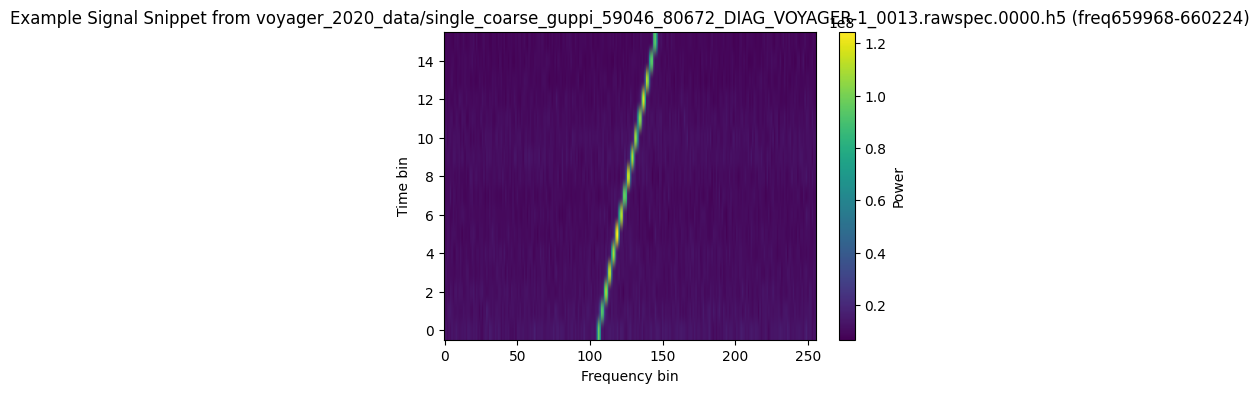

In [5]:
print(f"Total snippets extracted: {len(snippets)}")
  # Plot an example snippet (e.g., ninth snippet so idx = 8)
if snippets:
  idx = 8
  example = snippets[idx]
  plt.figure(figsize=(6,4))
  plt.imshow(example, aspect='auto', origin='lower', cmap='viridis')
  plt.colorbar(label='Power')
  plt.title(f"Example Signal Snippet from {snippet_locs[idx][0]} (freq{snippet_locs[idx][1]}-{snippet_locs[idx][2]})")
  plt.xlabel("Frequency bin")
  plt.ylabel("Time bin")
  plt.show()

Example spectrogram snippet (waterfall plot) of Voyager 1's carrier signal over ~5 minutes. The narrow diagonal line is the spacecraft’s radio carrier drifting in frequency due to relative motion (Doppler *drift*). We will use such snippets as inputs to the VAE encoder.

## Loading the Pretrained β-VAE Encoder Model

Peter Ma and colleagues trained a β-VAE on millions of such signal snippets to learn a compressed representation of signal morphologies. Here we will load the pretrained encoder model (which maps a 2D spectrogram snippet to a latent feature vector). The model file is hosted on GitHub, and we can download it directly.

In [11]:
!git clone https://github.com/PetchMa/Reverse_Radio_Search.git

Cloning into 'Reverse_Radio_Search'...
remote: Enumerating objects: 1245, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1245 (delta 34), reused 118 (delta 32), pack-reused 1117 (from 1)
Receiving objects: 100% (1245/1245), 137.06 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (656/656), done.
Updating files: 100% (132/132), done.


In [7]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Define the custom Sampling layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the autoencoder (same as before)
def build_autoencoder(input_shape=(16, 256, 1), latent_dim=5):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling(name='sampling')([z_mean, z_log_var])

    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation='relu')(decoder_input)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(2 * 8 * 32, activation='relu')(x)
    x = layers.Reshape((2, 8, 32))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(1, 2))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(1, 2))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(1, 2))(x)
    x = layers.Conv2DTranspose(16, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(1, 2))(x)
    decoded = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

    encoder = models.Model(inputs, z, name='encoder')
    decoder = models.Model(decoder_input, decoded, name='decoder')
    outputs = decoder(z)
    autoencoder = models.Model(inputs, outputs, name='autoencoder')
    return autoencoder, encoder

# === Build the model ===
autoencoder, encoder = build_autoencoder()

# ✅ Use TensorFlow checkpoint loading (required by Keras 3 for .index/.data files)
ckpt = tf.train.Checkpoint(model=autoencoder)
ckpt.restore("Reverse_Radio_Search/autoencoder/models/full-weights-12-15-2022-15-37-53").expect_partial()

# Test the encoder
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 16, 256,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 256,   │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 128,   │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 128,   │      4,640 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 64,    │      9,248 │ max_pooling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 32,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 32,    │      9,248 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │      9,248 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 8, 32) │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 8, 32) │        128 │ max_pooling2d_14… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4096)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │    131,104 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │        528 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 5)         │         85 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 5)         │         85 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 5)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 164,474 (642.48 KB)

 Trainable params: 164,410 (642.23 KB)

 Non-trainable params: 64 (256.00 B)

The encoder.summary() shows the layers of the model. It is a convolutional neural network that takes an input of shape (time, frequency, 1) – in our case, ~16 time bins × 256 freq bins × 1 channel – and outputs a latent vector (the encoded features). Note: The model expects a specific input shape that matches the training snippets. In the original paper, spectrograms were averaged to about 18.25 s per time bin, giving 16 time bins per 5-min snippet 11 . Our data has ~28 time bins (at ~10.7 s each) per snippet, which we need to adjust. To match the model, we will downsample each snippet’s time dimension to 16 bins.
For simplicity, we can do a rough downsampling by selecting 16 evenly spaced time slices from each snippet. (In a more rigorous approach, one could average or interpolate, but this quick method should retain the overall signal shape.) Let's prepare all snippets for input into the encoder:

In [18]:
# Prepare snippet array for model input
import math
snippets_array = []
for patch in snippets:
    t_bins, f_bins = patch.shape
    # Choose 16 time indices evenly from the snippet
    if t_bins >= 16:
        idx = np.linspace(0, t_bins-1, 16, dtype=int)
        patch_16 = patch[idx, :]
    else:
        # if somehow fewer than 16 (unlikely here), pad with last row
        pad_count = 16 - t_bins
        patch_16 = np.vstack([patch, np.tile(patch[-1,:], (pad_count, 1))])
    # Normalize or log-scale if needed (optional):
    # In practice, one might log10 transform and normalize each snippet as done in training.
# Here we assume the model was trained on linear power; we'll proceed without additional normalization.
    # Add channel dimension:
    patch_16 = np.expand_dims(patch_16, axis=-1)  # shape: 16 x 256 x 1
    snippets_array.append(patch_16)
snippets_array = np.array(snippets_array)
print("Input tensor shape for encoder:", snippets_array.shape)

Input tensor shape for encoder: (17, 16, 256, 1)


Now we pass this tensor through the encoder to get the latent embeddings for each snippet.

In [19]:
embeddings = encoder.predict(snippets_array)
print("Embeddings shape:", embeddings.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Embeddings shape: (17, 5)
